# DistilBERT

- manji model uči imitirati veći model
- zadržati što više znanja, ali uz manju arhitekturu (skoro duplo manje parametara i duplo manje slojeva)
- efikasnost 97% klasicnog Berta

In [1]:
from functorch.dim import softmax
!pip install datasets transformers torch scikit-learn shap

## Loading data
Emotions dataset : https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
dolazi u 3 skupa: train, validation, test
- linije u obliku text; emotion
- velicina skupa za treniranje = 16 000
- velicina validacijskog i testnog = 2 000

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# vraca Pandas dataframe sa stupcima "text" i "emotion"
def parse_emotion_file(file_path):
    texts = []
    emotions = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                text, emotion = line.strip().split(';')
                texts.append(text)
                emotions.append(emotion)
            except ValueError:
                continue
    return pd.DataFrame({'text': texts, 'emotion': emotions})

train_df = parse_emotion_file('train.txt')
val_df = parse_emotion_file('val.txt')
test_df = parse_emotion_file('test.txt')

In [4]:
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

Train size: (16000, 2)
Validation size: (2000, 2)
Test size: (2000, 2)


## Distribucija podataka

In [5]:
print(train_df['emotion'].value_counts())

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


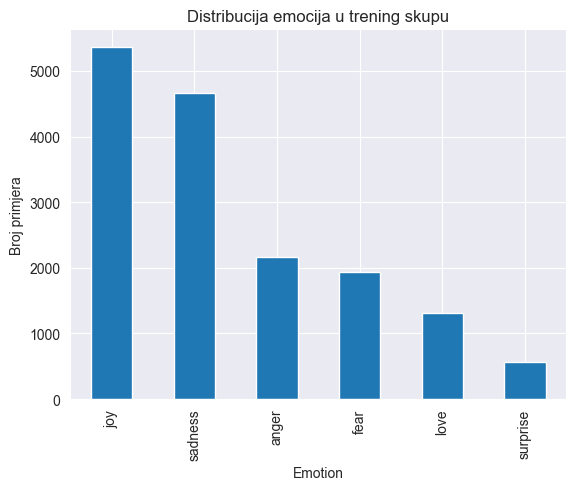

In [6]:
train_df['emotion'].value_counts().plot(kind='bar', title='Distribucija emocija u trening skupu')
plt.xlabel('Emotion')
plt.ylabel('Broj primjera')
plt.show()

Graf prikazuje disbalans u raspodjeli emocija – većina primjera pripada kategorijama joy i sadness, dok su ostale emocije prisutne u znatno manjem broju.

In [7]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Tokenizacija i priprema podataka

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model path for DistilBERT
model_name = "distilbert-base-uncased"

# loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

/Users/patricijamarijanovic/ZAVRSNI RAD/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# tokenizacija teksta u numeričke ID-jeve
# df = pandas sa stupcima "text", "emotion"
# label2id = mapiranje kategorija emocija u id
def preprocess_function(df, label2id):

    # tokenizacija stupca "text"
    tokenized_inputs = tokenizer(
        df['text'],
        padding='longest',
        truncation=True,
        max_length=512,
        return_tensors='pt' # vraća podatke kao PyTorch tenzore (torch.Tensor) umjesto Python lista
    ) # vraca rjecnik s kljucevima 'input_ids', 'attention_mask'

    tokenized_inputs["label"] = [label2id.get(emotion, -1) for emotion in df["emotion"]]
    return tokenized_inputs


In [10]:
from datasets import Dataset
# Pretvara običan Pandas DataFrame (train_df) u Hugging Face Dataset objekt
# korisno za batchanje
train_dataset = Dataset.from_pandas(train_df)

# jedinstvene kategorije
labels = train_df["emotion"].unique()
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}

# tokenizacija
train_dataset = train_dataset.map(lambda x : preprocess_function(x, label2id), batched=True)

Map: 100%|██████████| 16000/16000 [00:00<00:00, 25757.92 examples/s]


In [11]:
train_dataset[0]

{'text': 'i didnt feel humiliated',
 'emotion': 'sadness',
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'label': 0}

In [12]:
print(label2id)

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


# Fine-tuning

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, # "distilbert-base-uncased"
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT sastoji se od 5 slojeva + classification head (koristi izlaz iz tih slojeva za predviđanje kategorije)

Kako bi spriječili overfitting - freezing prva 4 sloja

In [14]:
# zamrzavanje svih slojeva osim petog i classifiera

for name, param in model.base_model.named_parameters():
    param.requires_grad = False # onemogucavam racunanje gradijenta za ove parametre

# samo su 5. sloj i classifier trainable
for name, param in model.base_model.named_parameters():
    if "transformer.layer.5" in name or "classifier" in name:
        param.requires_grad = True

# Metrike

Neuravnotožene kategorije emocija - neke su zastupljenije od drugih (joy, sadness)

--> accuracy nije najbolja metrika
- koristimo: precison, recall, F1 score, AUC score

In [15]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# izračunava accuracy, F1 score, precision, and recall
# p = tuple, predvidanja (logit, "sirove" izlazne vrijednosti iz modela (prije softmaxa)) i stvarne oznake (labels)
def compute_metrics(p):
    logits, labels = p

    # sve vrijednosti izmedu 0 i 1, zbroj = 1
    softmax = torch.nn.Softmax(dim=1);
    probs = softmax(torch.tensor(logits))

    # uzmi najvjerojatniju --> predvidena klasa
    preds = probs.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),  # Accuracy metric
        "f1_score": f1_score(labels, preds, average='weighted'),  # F1 score with weighted average for imbalanced data
        "precision": precision_score(labels, preds, average='weighted'),  # Precision score with weighted average
        "recall": recall_score(labels, preds, average='weighted'),  # Recall score with weighted average
        "auc_score": roc_auc_score(labels, probs, average="macro", multi_class="ovr")
    }

# Treniranje

In [16]:
# postavljanje hiperparametara
lr = 2e-5 # learning rate
batch_size = 16     # koliko se podataka obraduje odjednom
num_epochs = 3      # koliko puta prolazimo kroz citav skup za treniranje
weight_decay = 0.01 # sprječava prenaučenost penaliziranjem velikih težina

In [17]:
from transformers import TrainingArguments, Trainer
# training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_score",
    greater_is_better=True,
)

In [18]:
val_dataset = Dataset.from_pandas(train_df)
# tokenizacija
val_dataset = val_dataset.map(lambda x : preprocess_function(x, label2id), batched=True)

Map: 100%|██████████| 16000/16000 [00:00<00:00, 26241.86 examples/s]


In [19]:
# inicijalizacija modela
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# treniranje
print(f"Training {model_name}...")
trainer.train()

/var/folders/mk/drz6rhr972v4l3bn903sdl600000gn/T/ipykernel_60958/1912552796.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training distilbert-base-uncased...


Step,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall,Auc Score
500,1.204900,0.791852,0.716750,0.679469,0.723686,0.716750,0.924943
1000,0.729400,0.591156,0.789250,0.784908,0.787056,0.789250,0.958402
1500,0.609500,0.512860,0.820812,0.818681,0.819731,0.820812,0.967998
2000,0.555200,0.469428,0.837313,0.835348,0.835798,0.837313,0.972424
2500,0.508000,0.442999,0.843125,0.841657,0.841268,0.843125,0.975130
3000,0.502300,0.434855,0.847562,0.846640,0.846496,0.847562,0.976033


TrainOutput(global_step=3000, training_loss=0.6848727416992187, metrics={'train_runtime': 1475.4191, 'train_samples_per_second': 32.533, 'train_steps_per_second': 2.033, 'total_flos': 1034979515901504.0, 'train_loss': 0.6848727416992187, 'epoch': 3.0})

# Evaluacija modela

In [20]:
test_dataset = Dataset.from_pandas(train_df)
test_dataset = test_dataset.map(lambda x : preprocess_function(x, label2id), batched=True)

Map: 100%|██████████| 16000/16000 [00:00<00:00, 23526.99 examples/s]


In [21]:
# predictions on the test dataset with fine-tuned model
predictions_finetuned_model = trainer.predict(test_dataset)
preds_finetuned = predictions_finetuned_model.predictions.argmax(axis=1) # uzmi najvece vrijednosti

# evaluation metrics (accuracy, precision, recall, and F1 score)
eval_results_finetuned_model = compute_metrics((predictions_finetuned_model.predictions, test_dataset["label"]))


In [22]:
print(eval_results_finetuned_model)

{'accuracy': 0.8475625, 'f1_score': 0.8466396324861732, 'precision': 0.8464963616997556, 'recall': 0.8475625, 'auc_score': np.float64(0.9760332867348516)}


In [33]:
my_sentence = "I can't stand this anymore, i'm furious"
dummy_emotion = "joy"  # mora biti nešto iz label2id

# Pandas DataFrame
df = pd.DataFrame({
    "text": [my_sentence],
    "emotion": [dummy_emotion]
})

# HuggingFace Dataset
sentence_dataset = Dataset.from_pandas(df)

# Prilagodi preprocess function za samo predikciju (bez labela)
def preprocess_function_for_inference(df, label2id):
    # Samo tokenizacija, bez dodavanja labela
    tokenized_inputs = tokenizer(
        df['text'],
        padding='longest',
        truncation=True,
        max_length=512,
        return_tensors='pt'  # vraća podatke kao PyTorch tenzore
    )
    return tokenized_inputs

# Koristi mapiranje samo za tekst
sentence_dataset = sentence_dataset.map(lambda x: preprocess_function_for_inference(x, label2id), batched=True)

# Predikcija
prediction = trainer.predict(sentence_dataset)

# Uzmi klasu s najvećim scoreom
predicted_class = prediction.predictions.argmax(axis=1)[0]

# Ako imaš id2label mapu
predicted_label = id2label[predicted_class]
print(f"Predikcija emocije: {predicted_label}")

Map: 100%|██████████| 1/1 [00:00<00:00, 53.23 examples/s]


Predikcija emocije: anger
